# 目录
### 1. 导入模块
### 2. 导入泰坦尼克数据并分析
  - `x_train["age"].hist(bins=20)`
  - `x_train["sex"].value_counts().plot(kind="barh")`
  - `x_train["class"].value_counts().plot(kind="barh")`
  - `pd.concat([x_train,y_train], axis=1).groupby(by=["sex"]).survived.mean().plot(kind="barh")`
  
### 3. 定义Estimator的输入feature_columns
  - `tf.feature_column.indicator_column`
  - `tf.feature_column.categorical_column_with_vocabulary_list`
  - `tf.feature_column.numeric_column`
  
### 4. 使用tf.data.Dataset定义喂数据的迭代器
  - `tf.data.Dataset.from_tensor_slices`
  - `shuffle`
  - `repeat`
  - `batch`
  
### 5. 定义模型 
#### 5.1 keras接入数据层： `keras.layers.DenseFeatures` 衔接 feature_columns
#### 5.2 定义模型

### 6. keras 训练
  - `estimator.train`和`estimator.evaluate` 参数 `input_fn`: 
  - 1. 是一个函数；
  - 2. 这个函数是一个迭代器；
  - 3. 返回 （features, labels）数据, features是一个字典，才能与feature_columns对应
  
### 7. keras转estimizer训练
  - `keras.estimator.model_to_estimator`

## 1. 导入模块

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from tensorflow import keras
import tensorflow as tf
import sys
import os
import time
import datetime

for module in [np, pd, mpl, sklearn, keras, tf]:
    print(module.__name__, module.__version__)

numpy 1.18.1
pandas 0.25.3
matplotlib 3.1.2
sklearn 0.22.1
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf
tensorflow 2.1.0


## 2. 导入泰坦尼克数据并分析

In [2]:
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

# y_train y_eval 是 pd.Series 类型
y_train = train_df.pop("survived") # survived 这一列的数据从 train_df 中移除，并返回给 y_train
y_eval = eval_df.pop("survived")

x_train = train_df.copy()
x_eval = eval_df.copy()

x_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)

(627, 9) (627,)
(264, 9) (264,)


In [4]:
x_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


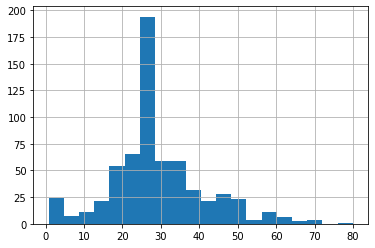

In [5]:
x_train["age"].hist(bins=20)

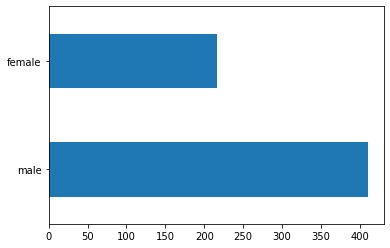

In [6]:
x_train["sex"].value_counts().plot(kind="barh")

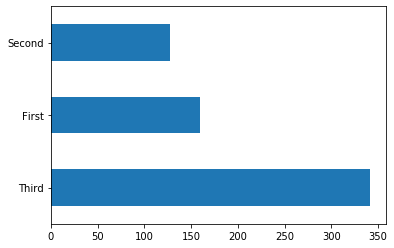

In [7]:
x_train["class"].value_counts().plot(kind="barh")

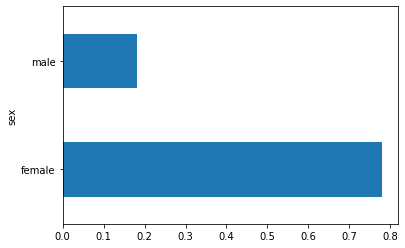

In [8]:
pd.concat([x_train,y_train], axis=1).groupby(by=["sex"]).survived.mean().plot(kind="barh")

## 3. 定义Estimator的输入feature_columns

In [9]:
numerical_columns = ["age", "fare"]
categorical_columns = list(set(x_train.columns.tolist()).difference(set(numerical_columns)))

feature_columns = []

# 离散数据的输入
for categorical_column in categorical_columns:
    vocab = x_train[categorical_column].unique()
    
    print(categorical_column, "---> ",vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(categorical_column, vocab) # 列名 --> 几种类别的列表
        )
    )

# 连续数据的输入
for numerical_column in numerical_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numerical_column, dtype=tf.float32   # 列名 --> 维度为0 的连续数据
        )
    )

n_siblings_spouses --->  [1 0 3 4 2 5 8]
class --->  ['Third' 'First' 'Second']
sex --->  ['male' 'female']
parch --->  [0 1 2 5 3 4]
deck --->  ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
alone --->  ['n' 'y']
embark_town --->  ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']


## 4. 使用tf.data.Dataset定义喂数据的迭代器

In [10]:
def make_dataset(train_df, label_df, shuffle=False, epochs=10, batch_size=32):
    '''
    train_df DataFrame 类型
    label_dfel  Series 类型
    '''
    # (features, labels), features 必须是一个字典类型，才能与feature_columns 的列名对应
    dataset = tf.data.Dataset.from_tensor_slices((dict(train_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

**打印看看**

In [11]:
test_dataset = make_dataset(x_train, y_train, batch_size=3)
for x, y in test_dataset.take(1):
    print(x)  # 返回的是一个字典类型
    print("====")
    print(y)

{'sex': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'male', b'female', b'female'], dtype=object)>, 'age': <tf.Tensor: shape=(3,), dtype=float64, numpy=array([22., 38., 26.])>, 'n_siblings_spouses': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 1, 0], dtype=int32)>, 'parch': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 7.25  , 71.2833,  7.925 ])>, 'class': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'Third', b'First', b'Third'], dtype=object)>, 'deck': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'unknown', b'C', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'Southampton', b'Cherbourg', b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'n', b'n', b'y'], dtype=object)>}
====
tf.Tensor([0 1 1], shape=(3,), dtype=int32)


## 5. 定义模型

### 5.1 keras接入数据层： `keras.layers.DenseFeatures` 衔接 feature_columns

In [12]:
test_dataset = make_dataset(x_train, y_train, batch_size=3)
for x, y in test_dataset.take(1):
    age_col = feature_columns[7]
    sex_col = feature_columns[0]
    print(keras.layers.DenseFeatures(age_col)(x).numpy()) #  接入age的输入，喂数据，提取出age数据
    print(keras.layers.DenseFeatures(sex_col)(x).numpy()) #  接入sex的输入，喂数据，提取出sex数据
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy()) # 接入feature_columns的输入，喂数据，提取出数据


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[22.]
 [38.]
 [26.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer construc

### 5.2 定义模型

In [13]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",  # 1. label 做onehot编码；2. 跟logits做交叉熵损失
    optimizer=keras.optimizers.SGD(lr=1e-3), 
    metrics=["accuracy"]  # 分类的度量
)

## 6. keras 训练

In [14]:
train_dataset = make_dataset(x_train, y_train, epochs=100, shuffle=True, batch_size=32)
eval_dataset = make_dataset(x_eval, y_eval, epochs=1, shuffle=False, batch_size=32)

model.fit(
    train_dataset, 
    validation_data=eval_dataset, 
    steps_per_epoch=x_train.shape[0]//32, 
    validation_steps=x_eval.shape[0]//32,
    epochs=100
)

Train for 19 steps, validate for 8 steps
Epoch 1/100
19/19 [==============================] - 1s 52ms/step - loss: 0.9124 - accuracy: 0.6612 - val_loss: 0.8568 - val_accuracy: 0.5039
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 1.0035 - accuracy: 0.6151 - val_loss: 0.8983 - val_accuracy: 0.4375
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.7093 - accuracy: 0.6414 - val_loss: 0.6545 - val_accuracy: 0.6602
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.7374 - accuracy: 0.6546 - val_loss: 0.9252 - val_accuracy: 0.4727
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.7807 - accuracy: 0.6234 - val_loss: 0.6630 - val_accuracy: 0.6133
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.7905 - accuracy: 0.6217 - val_loss: 0.6429 - val_accuracy: 0.6914
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.6489 - accuracy: 0.6678 - val_loss: 0

## 7. keras转estimator训练

In [15]:
estimizer = keras.estimator.model_to_estimator(model)

# input_fn: 
# 1. 是一个函数；
#2. 这个函数是一个迭代器；
#3. 返回 （features, labels）数据, features是一个字典，才能与feature_columns对应
estimizer.train(input_fn = lambda: make_dataset(x_train, y_train, shuffle=True, epochs=100, batch_size=32))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4bpjkjx2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas':

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.